## GAN

In [1]:
import torch
import torchvision
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
from torch.utils.data import DataLoader, Dataset # Gives easier dataset managment and creates mini batches
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

There are 20579 pictures of dogs.


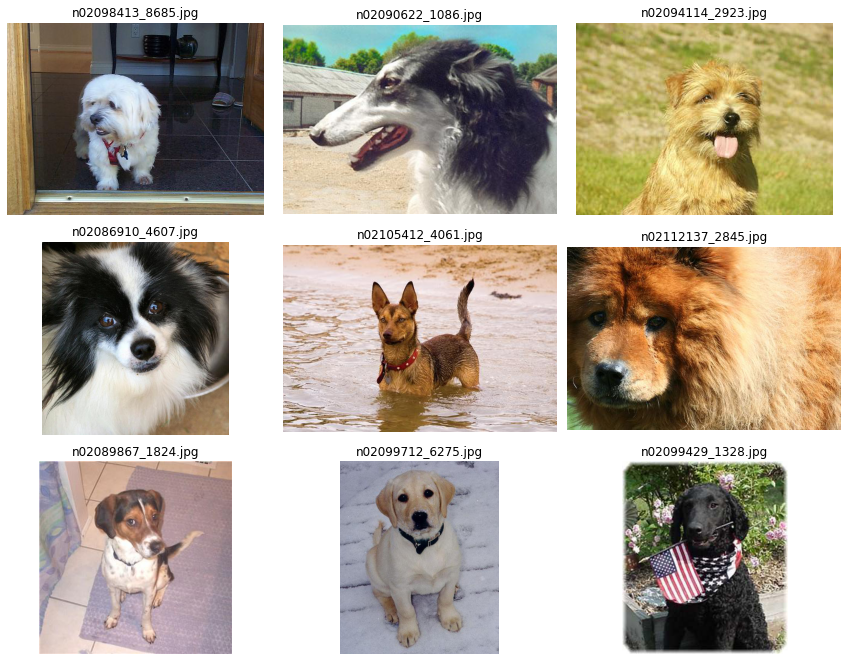

In [2]:
PATH = 'data/all-dogs/'
images = os.listdir(PATH)


print(f'There are {len(images)} pictures of dogs.')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))

for indx, axis in enumerate(axes.flatten()):
    rnd_indx = np.random.randint(0, len(os.listdir(PATH)))
    # https://matplotlib.org/users/image_tutorial.html
    img = plt.imread(PATH + images[rnd_indx])
    imgplot = axis.imshow(img)
    axis.set_title(images[rnd_indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [3]:
# Hyperparameters
lr = 0.0005
batch_size = 32
image_size = (225,225)
channels_img = 3
channels_noise = 1024
num_epochs = 20


# For how many channels Generator and Discriminator should use
features_d = 32
features_g = 32

In [4]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels_img, features_d, 4 , 3 , 1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features_d, features_d*2, 4 , 3 , 1),
            nn.BatchNorm2d(features_d*2),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features_d*2, features_d*4, 4, 2 , 1),
            nn.BatchNorm2d(features_d*4),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features_d*4, features_d*8, 4 , 2 , 0),
            nn.BatchNorm2d(features_d*8),
            nn.LeakyReLU(0.2),
            
            
            nn.Conv2d(features_d*8, 1 , 4 , 2 , 0),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        return self.net(x)
    
Discriminator(channels_img, features_d)

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2))
    (12): Sigmoid()
  )
)

In [5]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator,self).__init__()
        
        self.net = nn.Sequential(
            nn.ConvTranspose2d(channels_noise, features_g*16, 4, 2, 0),
            nn.BatchNorm2d(features_g*16),
            nn.ReLU(),
            
            nn.ConvTranspose2d(features_g*16, features_g*8, 4, 2, 1),
            nn.BatchNorm2d(features_g*8),
            nn.ReLU(),
            
            nn.ConvTranspose2d(features_g*8, features_g*4, 4, 3, 0),
            nn.BatchNorm2d(features_g*4),
            nn.ReLU(),
            
            nn.ConvTranspose2d(features_g*4, features_g*2, 5, 3, 1),
            nn.BatchNorm2d(features_g*2),
            nn.ReLU(),
            
            
            nn.ConvTranspose2d(features_g*2, channels_img, 5, 3, 1),
            nn.Tanh()
        )
    def forward(self, x):
        return self.net(x)
    
Generator(channels_noise, channels_img, features_g)

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(3, 3))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (13): Tanh()
  )
)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cpu


In [7]:
# Create discriminator and generator
netD = Discriminator(channels_img, features_d).to(device)
netG = Generator(channels_noise, channels_img, features_g).to(device)

In [8]:
my_transforms = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

# Setup Optimizer for G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

netG.train()
netD.train()

criterion = nn.BCELoss()

In [9]:
class DogDataset(Dataset):
    def __init__(self, img_dir, transform = None):
        self.img_dir = img_dir
        self.transform = transform
        self.images = os.listdir(img_dir)
        print(f"len of Dataset: {len(images)}")
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, index):
        image = Image.open(os.path.join(self.img_dir, self.images[index]))
        
        if self.transform:
            image = self.transform(image)
            
        return (image,1)

dog_dataset = DogDataset(PATH, my_transforms)
dog_dataset

len of Dataset: 20579


In [10]:
dataloader = DataLoader(dog_dataset, batch_size = batch_size, shuffle=True)
one_batch = next(iter(dataloader))
one_batch[0].shape

torch.Size([32, 3, 225, 225])

In [11]:
dimg = netD(one_batch[0])
dimg.shape

torch.Size([32, 1, 1, 1])

In [12]:
noise = torch.randn(batch_size, channels_noise, 1, 1)
netG(noise).shape

torch.Size([32, 3, 225, 225])

In [13]:
dimg = netD(one_batch[0])
dimg.shape

torch.Size([32, 1, 1, 1])

In [16]:
# train_data = datasets.ImageFolder('data/', transform=transform) this is the in-built fn in PyTorch

Saving fake_images-0000.png


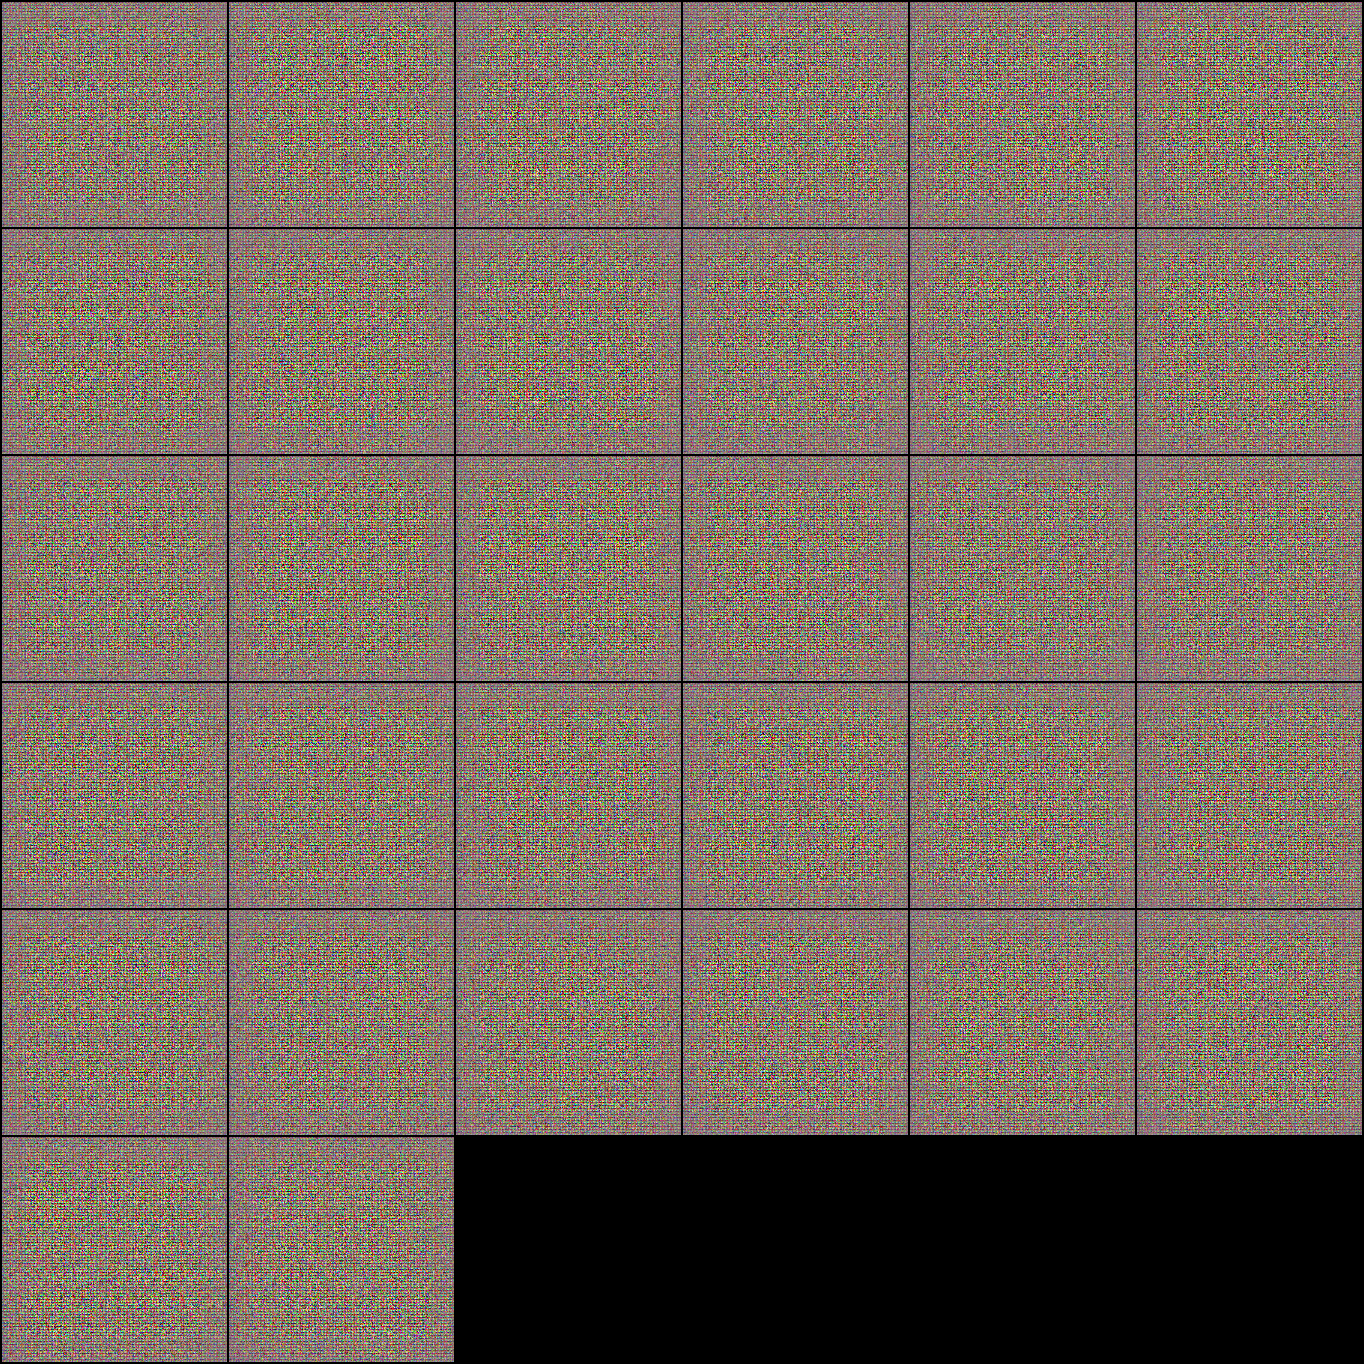

In [41]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def save_fake_images(index):
    noise = torch.randn(32, channels_noise, 1, 1).to(device)
    fake_images = netG(noise)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 225, 225)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), fake_fname, nrow=6)
    
# Before training
save_fake_images(0)
Image.open('fake_images-0000.png')

In [22]:
# train both generator and discriminator
def train(epochs):
    step = 0
    print("Started Training")
    fixed_noise = torch.randn(32, channels_noise, 1, 1).to(device)
    for epoch in range(epochs):
        for batch_idx, (image, label) in enumerate(dataloader):
            image = image.to(device)
            batch_size = image.shape[0]
            real_label = (label*0.9).to(device)
            
            ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
            netD.zero_grad()
            output = netD(image).reshape(-1)
            
            lossD_real = criterion(output, real_label)
            D_x = output.mean().item()
            
            noise = torch.randn(batch_size, channels_noise, 1, 1).to(device)
            fake = netG(noise) # image generated by Generator which is not real
            fake_label = (label * 0.1).to(device)
            
            output = netD(fake.detach()).reshape(-1) # detach as we don't want gradients from this
            
            lossD_fake = criterion(output, fake_label)
            
            lossD_total = lossD_fake + lossD_real
            lossD_total.backward()
            optimizerD.step()
            
            ## Train Generator: max log(D(G(z)))
            netG.zero_grad()
            output = netD(fake).reshape(-1)
            label = torch.ones(batch_size).to(device)
            # if discriminator tells that image is fake, then loss of gen is high
            lossG = criterion(output, label)
            lossG.backward()
            optimizerG.step()
            
            
            # Print losses ocassionally and print to tensorboard
            if batch_idx % 100 == 0:
                step += 1
                print(
                    f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} \
                      Loss D: {lossD_total:.4f}, loss G: {lossG:.4f} D(x): {D_x:.4f}"
                )
        save_fake_images(epoch)

#                 with torch.no_grad():
#                     fake = netG(fixed_noise)
#                     img_grid_real = torchvision.utils.make_grid(image[:32], normalize=True)
#                     img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
#                     writer_real.add_image(
#                         "Mnist Real Images", img_grid_real, global_step=step
#                     )
#                     writer_fake.add_image(
#                         "Mnist Fake Images", img_grid_fake, global_step=step
#                     )
train(num_epochs)          

Started Training
all clear
Epoch [0/20] Batch 0/644                       Loss D: 3.8771, loss G: 4.2220 D(x): 0.8708
all clear
all clear
all clear


KeyboardInterrupt: 

In [16]:
one_batch[0][0].shape

torch.Size([3, 225, 225])

In [14]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import save_image


img_norm =
# trans = transforms.ToPILImage()
save_image( denorm(one_batch[0][0]),"./image_1.jpg")